## Load dataset

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


train_separable = pd.read_csv('../../input/A2-ring/A2-ring-separable.txt', sep="\t", header=None)
train_merged = pd.read_csv('../../input/A2-ring/A2-ring-merged.txt', sep="\t", header=None)
test = pd.read_csv('../../input/A2-ring/A2-ring-test.txt', sep="\t", header=None)
columns = ['Feature1', 'Feature2', 'Class']
train_separable.columns, train_merged.columns, test.columns = columns, columns, columns

X_train = train_separable.iloc[:, :-1]
y_train = train_separable.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]



## Train the BP Model

In [2]:
bp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=1)
bp_model.fit(X_train, y_train)


MLPClassifier(max_iter=500, random_state=1)

## Model Evaluation

In [3]:
y_pred = bp_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
classification_error = 100 * (fp + fn) / float(tn + fp + fn + tp)
print(f"Classification Error: {classification_error}%")


Classification Error: 3.53%


## ROC Curve

ROC Curve Values (BP):
Threshold: inf - FPR: 0.000, TPR: 0.000
Threshold: 1.00 - FPR: 0.000, TPR: 0.000
Threshold: 0.96 - FPR: 0.000, TPR: 0.646
Threshold: 0.96 - FPR: 0.000, TPR: 0.646
Threshold: 0.96 - FPR: 0.000, TPR: 0.647
Threshold: 0.96 - FPR: 0.000, TPR: 0.647
Threshold: 0.96 - FPR: 0.000, TPR: 0.653
Threshold: 0.96 - FPR: 0.001, TPR: 0.653
Threshold: 0.96 - FPR: 0.001, TPR: 0.655
Threshold: 0.96 - FPR: 0.001, TPR: 0.655
Threshold: 0.96 - FPR: 0.001, TPR: 0.657
Threshold: 0.96 - FPR: 0.001, TPR: 0.657
Threshold: 0.95 - FPR: 0.001, TPR: 0.667
Threshold: 0.95 - FPR: 0.001, TPR: 0.667
Threshold: 0.95 - FPR: 0.001, TPR: 0.668
Threshold: 0.95 - FPR: 0.001, TPR: 0.668
Threshold: 0.95 - FPR: 0.001, TPR: 0.670
Threshold: 0.95 - FPR: 0.002, TPR: 0.670
Threshold: 0.95 - FPR: 0.002, TPR: 0.676
Threshold: 0.95 - FPR: 0.002, TPR: 0.676
Threshold: 0.95 - FPR: 0.002, TPR: 0.678
Threshold: 0.95 - FPR: 0.002, TPR: 0.678
Threshold: 0.95 - FPR: 0.002, TPR: 0.678
Threshold: 0.95 - FPR: 0.002, TPR: 

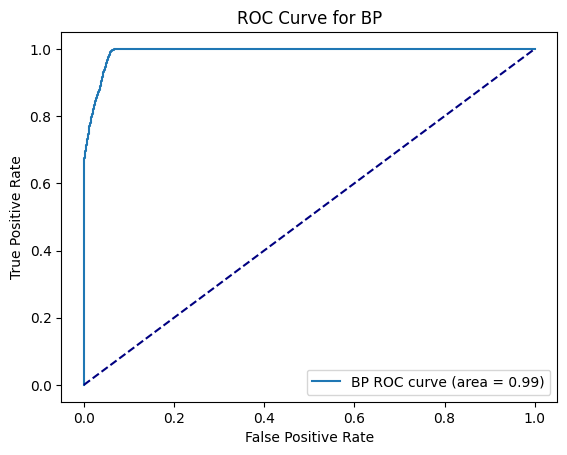

In [6]:
from sklearn.metrics import roc_curve, auc

# predict probabilities for the positive class
y_pred_proba_bp = bp_model.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC for BP
fpr_bp, tpr_bp, thresholds_bp = roc_curve(y_test, y_pred_proba_bp)
auc_bp = auc(fpr_bp, tpr_bp)

# print ROC and AUC values
print("ROC Curve Values (BP):")
for fpr, tpr, thr in zip(fpr_bp, tpr_bp, thresholds_bp):
    print(f"Threshold: {thr:.2f} - FPR: {fpr:.3f}, TPR: {tpr:.3f}")

print(f"\nArea Under Curve (AUC) for BP: {auc_bp:.3f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_bp, tpr_bp, label=f'BP ROC curve (area = {auc_bp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BP')
plt.legend(loc="lower right")
plt.show()
